In [40]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [41]:
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2
BATCH_SIZE = 16

In [42]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/yoga_proj'
!ls /content/gdrive/MyDrive/yoga_proj
# base_path = '../'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data		      nov16_third_run	       nov22_DA		    official_dataset
nov16_second_run      nov16_unknown_attention  nov22_DA_longer
nov16_test_third_run  nov20_third_run	       nov24_weighted_loss


In [43]:
import os

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')

SAVE_PATH = os.path.join(base_path, 'nov24_weighted_loss')
os.makedirs(SAVE_PATH, exist_ok=True)

# Classification classes
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)

dataset_dir = os.path.join(base_path, 'official_dataset')
assert os.path.isdir(dataset_dir), f"Directory '{dataset_dir}' does not exist."


In [44]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.5.1+cu121


In [45]:
meta_info_path = os.path.join(base_path, 'data')
pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')

pose_index.head()

,level1_id,level1_pose,level2_id,level2_pose,l3_pose_id,13_pose
0,1,standing,11,standing-straight,101,mountain
1,1,standing,11,standing-straight,102,goddess
2,1,standing,11,standing-straight,103,eagle
3,1,standing,11,standing-straight,104,tree
4,1,standing,11,standing-straight,105,chair


In [46]:
list_poses = [p for p in sequence_index['l3_pose']]
pose_dict = dict()
for poses in list_poses:
    if poses in pose_dict:
        pose_dict[poses] += 1
    else:
        pose_dict[poses] =1
sorted_poses = sorted(pose_dict.items(), key= lambda item: item[1], reverse=True)
print(sorted_poses[:20])
for p, c in sorted_poses[:20]:
    print(f"'{p}'",end=",")
poses = ['mountain',
'half-way-lift',
'standing-forward-bend',
'downward-dog',
'high-lunge',
'low-lunge',
'warrior-3',
'side-plank',
'balancing-table',
'child',
'tree',
'extended-triangle',
'bridge']
for keys in poses:
    print(keys, pose_dict[keys])

sum(map(lambda k: pose_dict[k], poses))

[('downward-dog', 245), ('standing-forward-bend', 225), ('half-way-lift', 209), ('mountain', 165), ('chair', 140), ('cobra', 129), ('cockerel', 120), ('extended-triangle', 108), ('extended-side-angle', 101), ('corpse', 95), ('staff', 94), ('wind-relieving', 94), ('fish', 93), ('happy-baby', 93), ('shoulder-pressing', 92), ('reclining-cobbler', 91), ('reclining-hero', 82), ('frog', 80), ('tree', 69), ('intense-side-stretch', 59)]
'downward-dog','standing-forward-bend','half-way-lift','mountain','chair','cobra','cockerel','extended-triangle','extended-side-angle','corpse','staff','wind-relieving','fish','happy-baby','shoulder-pressing','reclining-cobbler','reclining-hero','frog','tree','intense-side-stretch',mountain 165
half-way-lift 209
standing-forward-bend 225
downward-dog 245
high-lunge 42
low-lunge 44
warrior-3 47
side-plank 48
balancing-table 44
child 47
tree 69
extended-triangle 108
bridge 41


1334

What does each file tell?

1.) pose-index.csv -> Shows Heirarchical organization (THEN NOTHING MORE)

2.) 3DYoga90.csv -> Total Main Info(i.e. along with RGB stream){
    SequneceID: Parquet_FILE_NAME,
    URL,
    Frame Start and Frame Stop,
    Pose Name, Training Test Split
} `Difference between train and test? where to get the validation set from? How to do data augmentation?

3.) Parquet Files -> {
    Frame Number {
        33 Landmarks
    },
    row-id: FrameNumber-TYPE-Landmark_index,
    Coordinates: {x, y, z}
}

`PLEASE NOTE: The landmark coordinates are all normalized`

# Getting the data ready

In [47]:
the_desired_poses = [
  'downward-dog',
  'high-lunge',
  'low-lunge',
  'warrior-3',
  'side-plank',
  'balancing-table',
  'child',
  'tree',
  'extended-triangle',
  'bridge']

# subset_of_poses = [
#   'mountain',
#   'downward-dog',
#   'standing-foward-bend',
#   'half-way-lift'
# ]

subset_of_poses = pose_list

In [48]:
# Keep only relevant columns
def read_meta_data():
    meta_info_path = os.path.join(base_path, 'data')
    pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
    sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')
    parquet_index = sequence_index[['sequence_id', 'l3_pose', 'split']]
    return parquet_index

In [49]:
import torch
import torch.nn.functional as F
import numpy as np

def AddGaussianNoise(data, mean=0., std=0.01):
    noise = torch.randn_like(data) * std + mean
    return data + noise

def RandomRotate(data, max_angle=30):
    angle = torch.rand(1) * 2 * max_angle - max_angle  # Range: [-max_angle, max_angle] in degrees
    angle_rad = torch.deg2rad(angle)
    cos_theta = torch.cos(angle_rad)
    sin_theta = torch.sin(angle_rad)

    rotation_matrix = torch.tensor([
        [cos_theta, 0, sin_theta],
        [0, 1, 0],
        [-sin_theta, 0, cos_theta]
    ]).squeeze()

    # print(data.shape)
    # print(rotation_matrix.shape)
    # data = torch.matmul(rotation_matrix, data)
    data = torch.einsum('ij, jkl -> ikl', rotation_matrix, data)
    return data

def RandomScale(data, scale_range=(0.9, 1.1)):
    scale =  scale_range[0] + torch.rand(1) * (scale_range[1] - scale_range[0]) # 0.9 + 0.2 * percentage
    return data * scale

def RandomTranslate(data, max_translate=0.1):
    translate = torch.rand(3) * 2 * max_translate - max_translate  # Range: [-max_translate, max_translate]
    return data + translate.unsqueeze(1).unsqueeze(2)

def TimeReverse(data, p=0.5):
    if torch.rand(1) < p:
        return torch.flip(data, [1])
    else:
        return data

In [50]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class Yoga3DDataset(Dataset):
    def __init__(self, parquet_index, root_dir =  dataset_dir,subset_of_poses= subset_of_poses, sub_sampling_length = 20, transform=None, max_frames=None):
        self.parquet_index = parquet_index
        self.parquet_index = self.parquet_index[self.parquet_index['l3_pose'].isin(subset_of_poses)]
        self.root_dir = root_dir
        self.transform = transform
        self.max_frames = max_frames
        self.sub_sampling_length = sub_sampling_length
        self.pose_to_label = {pose: i for i, pose in enumerate(subset_of_poses)}
        self.use_augmentation = False

        self.cache = dict()
        self.idx_to_seq = dict()

    def __len__(self):
        return len(self.parquet_index)

    def __getitem__(self, idx):
        if idx in self.cache:
            data, label = self.cache[idx]
        else:
            fname, pose_name, _ = self.parquet_index.iloc[idx]
            label = self.pose_to_label[pose_name]


            path = os.path.join(self.root_dir, f'{fname}.parquet')

            df = pd.read_parquet(path)
            df = df.drop(columns=['frame', 'row_id', 'type','landmark_index'])

            data = self.to_tensor(df)
            data = self.sub_sample(data)
            data = data.permute(1,0,2)
            self.cache[idx] = (data, label)
            self.idx_to_seq[idx] = fname

        if self.transform and self.use_augmentation:
            data = self.transform(data.clone())

        return data, label # C, T , V

    def sub_sample(self, data):
        # data(Number_of_frames, 3, 33)
        total_frames = data.shape[0]
        indices = torch.linspace(0, total_frames -1 , self.sub_sampling_length, dtype= int)
        return data[indices]

    def to_tensor(self, df):
        # Reshape the data to (num_frames, num_landmarks, 3)  ## WHAT WHAT? this doesn't make sense remove this line you are doing (number of frames, 3 , 33)
        num_frames = len(df) // 33  # Assuming 33 landmarks per frame
        data = df.values.reshape(num_frames, 33, 3)
        return torch.FloatTensor(data).permute(0, 2, 1)

In [51]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

In [52]:
class RandomApply:
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, data):
        if torch.rand(1) < self.p:
            return self.transform(data)
        else:
            return data

In [53]:
import torch.nn as nn

class AGCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AGCN, self).__init__()

        # Initialize adjacency matrix for BlazePose (33 joints)
        self.num_nodes = 33
        # Define the natural connections in BlazePose skeleton
        self.edges = [
            # Torso
            (11, 12), (12, 24), (24, 23), (23, 11),  # shoulders to hips
            # Right arm
            (12, 14), (14, 16), (16, 18), (18, 20), (20, 22),  # shoulder to fingertip
            # Left arm
            (11, 13), (13, 15), (15, 17), (17, 19), (19, 21),  # shoulder to fingertip
            # Right leg
            (24, 26), (26, 28), (28, 30), (30, 32),  # hip to foot
            # Left leg
            (23, 25), (25, 27), (27, 29), (29, 31),  # hip to foot
            # Face
            (0, 1), (1, 2), (2, 3), (3, 7),  # right eye
            (0, 4), (4, 5), (5, 6), (6, 8),  # left eye
            (9, 10),  # mouth
            # Add connections to nose (0) from shoulders
            # (0, 11), (0, 12)  # do we include this connection dear friend?
        ]

        # Create adjacency matrix
        A = np.zeros((self.num_nodes, self.num_nodes))
        for i, j in self.edges:
            A[i, j] = 1
            A[j, i] = 1  # Undirected graph

        # Convert to tensor and make it a parameter
        self.A = nn.Parameter(torch.from_numpy(A.astype(np.float32)))

        # Create identity matrix
        self.identity = nn.Parameter(torch.eye(self.num_nodes), requires_grad=False)

        # 1x1 convolution for feature transformation
        self.W = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Compute degree matrix
        D = torch.sum(self.A, dim=1)
        D = torch.diag(torch.pow(D, -0.5))
        # D_r = torch.diag(torch.pow(D, 0.5))

        # Normalized adjacency matrix
        A_norm = torch.matmul(torch.matmul(D, self.A + self.identity), D)

        # Reshape input for matrix multiplication
        # N, C, T, V = x.size()
        x_reshape = x.permute(0, 2, 3, 1).contiguous()  # N, T, V, C
        # Apply GCN operation
        x_gc = torch.matmul(A_norm, x_reshape)  # N, T, V, C

        # Reshape back
        x_gc = x_gc.permute(0, 3, 1, 2).contiguous()  # N, C, T, V

        # Apply 1x1 convolution
        out = self.W(x_gc)

        return out


In [54]:
# agcn = AGCN(3, 64)
# D = torch.sum(agcn.A, dim=1)
# D = torch.diag(torch.pow(D, -0.5))
# A_norm = torch.matmul(torch.matmul(D, agcn.A + agcn.identity), D)
# # A_norm
# agcn.A.shape
# D.shape
# torch.matmul(torch.matmul(D, agcn.A + agcn.identity), D)

![image.png](attachment:image.png)

In [55]:
class STSAM(nn.Module):
    def __init__(self, in_channels):
        super(STSAM, self).__init__()

        # 1x1 convolutions for Q, K, V
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # 1x1 convolutions for scaling attention maps
        self.Ws = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.Wt = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        N, C, T, V = x.size()

        # Generate Q, K, V
        Q = self.query_conv(x)
        K = self.key_conv(x)
        V = self.value_conv(x)

        # Spatial attention
        Qs = torch.mean(Q, dim=2, keepdim=True)  # (N, C, 1, V)
        Ks = torch.mean(K, dim=2, keepdim=True)  # (N, C, 1, V)
        Vs = torch.mean(V, dim=2, keepdim=True)  # (N, C, 1, V)

        # Temporal attention
        Qt = torch.mean(Q, dim=3, keepdim=True)  # (N, C, T, 1)
        Kt = torch.mean(K, dim=3, keepdim=True)  # (N, C, T, 1)
        Vt = torch.mean(V, dim=3, keepdim=True)  # (N, C, T, 1)

        # Compute attention maps
        Ms = torch.matmul(Qs.transpose(2, 3), Ks) / torch.sqrt(torch.tensor(C, dtype=torch.float))  # Spatial attention
        Ms = torch.softmax(Ms, dim=-1)
        Ms = torch.matmul(Ms, Vs.transpose(2, 3)).transpose(2, 3)

        Mt = torch.matmul(Qt.transpose(2, 3), Kt) / torch.sqrt(torch.tensor(C, dtype=torch.float))  # Temporal attention
        Mt = torch.softmax(Mt, dim=-1)
        Mt = torch.matmul(Mt, Vt.transpose(2, 3)).transpose(2, 3)

        # Scale attention maps
        Ms1 = torch.sigmoid(self.Ws(Ms))  # (N, 1, 1, V)
        Mt1 = torch.sigmoid(self.Wt(Mt))  # (N, 1, T, 1)

        # Apply attention with residual connections
        out = (x + x * Ms1) + (x + x * Mt1)

        return out

In [56]:
import torch
import torch.nn as nn

class MTCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=None):
        super(MTCN, self).__init__()

        # If hidden_channels not specified, make it divisible by 6
        if hidden_channels is None:
            hidden_channels = in_channels - (in_channels % 6)

        assert hidden_channels % 6 == 0, "var: hidden_channels should always be multple of 6 because 6 branches"

        self.branch_channels = hidden_channels // 6

        # Initial 1x1 conv to reduce channels
        self.init_conv = nn.Conv2d(
            in_channels,
            hidden_channels,
            kernel_size=1
        )

        # Branch 1: 1x1 Conv
        self.branch1 = nn.Conv2d(
            hidden_channels,
            self.branch_channels,
            kernel_size=1
        )

        # Branch 2: Max Pooling followed by 1x1 Conv to adjust channels
        self.branch2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 3), padding=(0, 1), stride=1),
            nn.Conv2d(hidden_channels, self.branch_channels, kernel_size=1)
        )

        # Branches 3-6: 1D Conv with different dilations
        self.branches = nn.ModuleList([
            nn.Conv2d(
                hidden_channels,
                self.branch_channels,
                kernel_size=(1, 3),
                padding=(0, dilation),
                dilation=(1, dilation)
            ) for dilation in range(1, 5)
        ])

        # Final 1x1 conv to restore original channel count
        self.final_conv = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)

    def forward(self, x):
        # x shape: (batch_size, C, V, T)

        # Initial channel reduction
        x = self.init_conv(x)

        # Process each branch
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)

        # Process dilated convolution branches
        branch_outputs = [branch1, branch2]
        for branch in self.branches:
            branch_outputs.append(branch(x))

        # Concatenate all branch outputs
        x = torch.cat(branch_outputs, dim=1)

        # Final 1x1 conv
        x = self.final_conv(x)

        return x

In [57]:

class STSAE_GCN_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(STSAE_GCN_Block, self).__init__()
        self.agcn = AGCN(in_channels, out_channels)
        self.stsam = STSAM(out_channels)
        self.mtcn = MTCN(out_channels, 48)

    def forward(self, x):
        x = self.agcn(x)
        x = self.stsam(x)
        x = self.mtcn(x)
        return x

class STSAE_GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_frames, num_blocks=9):
        super(STSAE_GCN, self).__init__()
        self.num_blocks = num_blocks

        self.blocks = nn.ModuleList([
            STSAE_GCN_Block(in_channels if i == 0 else hidden_channels,
                            hidden_channels)
            for i in range(num_blocks)
        ])
        num_nodes = 33
        self.fc = nn.Linear(hidden_channels * num_nodes * num_frames, num_classes)

    def forward(self, x):
        # x shape: (batch_size, in_channels, num_frames, num_nodes)
        for block in self.blocks:
            x = block(x)

        # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")


In [58]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, save_path = SAVE_PATH, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [59]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [60]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [61]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, dataset, num_epochs=50, patience=18, log_interval=10, checkpoint_path=None, unfreeze_epoch=5, num_layers_unfreeze=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        dataset.use_augmentation = True
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels) in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Pass sequence lengths to model forward function
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (BATCH_SIZE * (batch_idx + 1)),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='weighted')
        train_recall = recall_score(train_true, train_pred, average='weighted')
        train_f1 = f1_score(train_true, train_pred, average='weighted')

        dataset.use_augmentation = False
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Pass sequence lengths to model forward function
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (BATCH_SIZE * (batch_idx + 1)),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='weighted')
        val_recall = recall_score(val_true, val_pred, average='weighted')
        val_f1 = f1_score(val_true, val_pred, average='weighted')

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(SAVE_PATH, 'best_model.pth')
            if best_model_path is not None:
                print(best_model_path)
            save_checkpoint(model, optimizer, epoch, history, SAVE_PATH, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history



In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names,spath=SAVE_PATH, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [63]:
from torch.utils.data import random_split, DataLoader

def train_val_test_split(dataset, test_split = TEST_SPLIT, val_split= VAL_SPLIT):
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        # num_workers=2,
        pin_memory= True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=2,
        pin_memory= True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=2
    )

    return train_loader, val_loader, test_loader

In [64]:

def plot_training_curves(history, fsave='training_curves.png'):
    tsave = os.path.join(SAVE_PATH, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [103]:
import numpy as np
import torch
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(pose_list, num_classes, strategy='balanced'):
    """
    Calculate class weights with proper class index alignment.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy ('balanced', 'inverse', 'effective_samples', 'sqrt_inverse')

    Returns:
        torch.Tensor: Class weights tensor aligned with class indices
    """
    # Count samples per class
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    # Initialize weights array with zeros for all possible classes
    weights = np.zeros(num_classes)

    if strategy == 'balanced':
        # Use sklearn's balanced weighting
        unique_classes = sorted(class_counts.keys())
        sklearn_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array(unique_classes),
            y=pose_list
        )
        # Map weights to correct indices
        for idx, class_label in enumerate(unique_classes):
            weights[class_label] = sklearn_weights[idx]

    elif strategy == 'inverse':
        # Inverse of sample frequency
        for class_label, count in class_counts.items():
            weights[class_label] = total_samples / (num_classes * count)

    elif strategy == 'effective_samples':
        # Effective number of samples weighting
        beta = 0.9999
        for class_label, count in class_counts.items():
            weights[class_label] = (1 - beta) / (1 - beta ** count)

    elif strategy == 'sqrt_inverse':
        # Square root of inverse frequency
        for class_label, count in class_counts.items():
            weights[class_label] = np.sqrt(total_samples / (num_classes * count))

    else:
        raise ValueError(f"Unknown weighting strategy: {strategy}")

    # Convert to tensor and normalize
    weights = torch.FloatTensor(weights)
    weights = weights / weights.sum() * len(weights)

    return weights

def create_weighted_criterion(pose_list, num_classes, strategy='balanced'):
    """
    Create a weighted CrossEntropyLoss criterion.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy for calculating class weights

    Returns:
        nn.CrossEntropyLoss: Weighted loss criterion
    """
    weights = get_class_weights(pose_list, num_classes, strategy)
    print("Class weights aligned with indices:", weights)
    if torch.cuda.is_available():
        weights = weights.cuda()
    return nn.CrossEntropyLoss(weight=weights)

def analyze_class_distribution(pose_list):
    """
    Analyze and print class distribution information.

    Args:
        pose_list: List of labels/poses in the dataset
    """
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    print("\nClass Distribution Analysis:")
    print("-" * 50)
    for class_idx, count in sorted(class_counts.items()):
        percentage = (count / total_samples) * 100
        print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

    # Calculate imbalance metrics
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count

    print("\nImbalance Statistics:")
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
    print(f"Maximum class size: {max_count}")
    print(f"Minimum class size: {min_count}")
    print(f"Average class size: {total_samples/len(class_counts):.2f}")

In [110]:
def main(in_channels = 3, hidden_channels= 64, num_classes= NUM_CLASSES, num_frames= 20, LR = 0.0001, Epochs =50):
    transforms = Compose([
        RandomApply(AddGaussianNoise, p=0.5),
        RandomApply(RandomRotate, p=0.5),
        RandomApply(RandomScale, p=0.5),
        RandomApply(RandomTranslate, p=0.5),
        # TimeReverse(p=0.5)
        # Normalize,
    ])

    dataset = Yoga3DDataset(read_meta_data(), transform=transforms)
    train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
    train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

    print("start")
    all_labels = [dataset[i][1] for i in range(len(dataset))]
    print("Finished")
    analyze_class_distribution(all_labels)

    # Create weighted loss criterion
    criterion = create_weighted_criterion(
        all_labels,
        num_classes= NUM_CLASSES,
        strategy='effective_samples'  # Try different strategies
    )
    model = STSAE_GCN(in_channels, hidden_channels, num_classes, num_frames)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)


    print("Training the model")
    checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')

    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        dataset,
        Epochs,
        patience=20,
        log_interval=1,
        checkpoint_path=None
    )
    # Plot the training curves
    plot_training_curves(history)
    if checkpoint_path and os.path.exists(checkpoint_path):
            model, optimizer, start_epoch, history = load_checkpoint(
                model, optimizer, checkpoint_path
            )
            print(f"Resuming training from epoch {start_epoch}")
    evaluate_model(model, test_loader, criterion, pose_list)

    model_save_path = os.path.join(SAVE_PATH, 'my_model.pth')
    torch.save(model.state_dict(), model_save_path)

In [108]:
if __name__ == "__main__":
    main()

TypeError: TimeReverse() missing 1 required positional argument: 'data'

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm
import csv

def find_sus(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix_all.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    sussave = os.path.join(spath, 'sus.csv')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    misclassified_data = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Check if the sample is misclassified
            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            for misclassified_idx in misclassified_indices:
                global_idx = batch_idx * inputs.size(0) + misclassified_idx.item()
                sequence_id = test_loader.dataset.idx_to_seq[global_idx]
                correct_label = class_names[labels[misclassified_idx].item()]
                prediction = class_names[predicted[misclassified_idx].item()]
                misclassified_data.append([sequence_id, correct_label, prediction])

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=pose_list, yticklabels=pose_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    # Save misclassified data to CSV
    with open(sussave, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['sequence_id', 'correct_label', 'prediction'])
        writer.writerows(misclassified_data)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

Class weights aligned with indices: tensor([1.2515, 0.9880, 0.9177, 0.8428])
Loading checkpoint from /content/gdrive/MyDrive/yoga_proj/nov24_weighted_loss/best_model.pth
Resuming training from epoch 10


Testing: 100%|██████████| 53/53 [00:01<00:00, 39.62it/s]


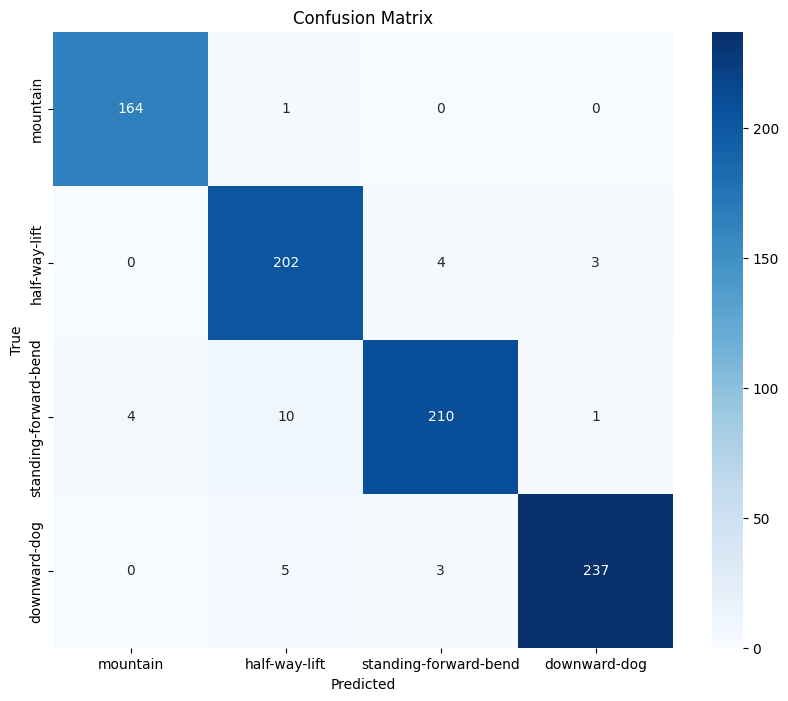

Test Loss: 0.1457
Test Accuracy: 96.33%


(0.14573716442321397, 96.32701421800948)

In [106]:
dataset = Yoga3DDataset(read_meta_data())
label_to_pose = {v:k for k,v in dataset.pose_to_label.items()}

model = STSAE_GCN(3, 64, 4, 20)
# criterion = nn.CrossEntropyLoss()
all_labels = [dataset[i][1] for i in range(len(dataset))]
criterion = create_weighted_criterion(
        all_labels,
        num_classes= NUM_CLASSES,
        strategy='inverse'  # Try different strategies
    )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
# Plot the training curves
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
# plot_training_curves(history)
find_sus(model, loader, criterion, label_to_pose)